# CAS 522 - Dynamical Methods for Complex Systems Science </br>
# Module 7: Visualizations of Dynamical Models </br>
*This jupyter notebook is the submission for Heather Tottingham to fulfill the Module 7 (Final Project) assignment for Fall 2025.*

For my final project for CAS-522, I chose to examine a data set from Yellowstone National Park. This data set includes information about the growth of aspen trees, whether plots of trees were grazed (browsed) by elk, the density of elk, and the density of wolves, all by year. 
<br> We know that the observations of dynamical systems are often limited in time. We also know that short-term observations could hide global effects like the finite resources of the environment that make logistic growth a more realistic model than the simpler exponential growth model. So, building the model is an iterative process where additional observations/variables might be required to refine the model with the correct number of positive and negative feedback terms, because their interplay determines the adaptive behavior we see in the real world. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
from scipy import integrate
import ipywidgets as ipw

In [6]:
df = pd.read_csv(r'C:/Users/hatot/OneDrive/Documents/ASU/Fall 2025 A/CAS 522 Dynamical Methods for Complex System Science/Module 7/BriceEtAl2024_Data.csv')

In [7]:
df.head()

,Plot,Year,Browse,Height,Wolf_Density_Aggregate,Wolf_Density_Annual,All_Elk_Kills_Aggregate,All_Elk_Kills_Annual,Male_Elk_Kills_Aggregate,Male_Elk_Kills_Annual,...,Openness,Smoothness,Elk_AnnualCount,Elk_Density,Precipitation_cm,SWE_tons,Fire,Height_Scaled,Height_Spline1,Height_Spline2
0,1,1999,1,73.0,0.00009,0.000043,2.220000e-09,2.670000e-09,4.350000e-10,4.360000e-15,...,0.77,0.74,13422,13.49,17.04,14.49,0,-0.26,-0.26,0.0
1,1,1999,1,34.0,0.00009,0.000043,2.220000e-09,2.670000e-09,4.350000e-10,4.360000e-15,...,0.77,0.74,13422,13.49,17.04,14.49,0,-0.71,-0.71,0.0
2,1,1999,1,55.0,0.00009,0.000043,2.220000e-09,2.670000e-09,4.350000e-10,4.360000e-15,...,0.77,0.74,13422,13.49,17.04,14.49,0,-0.47,-0.47,0.0
3,1,1999,1,18.0,0.00009,0.000043,2.220000e-09,2.670000e-09,4.350000e-10,4.360000e-15,...,0.77,0.74,13422,13.49,17.04,14.49,0,-0.90,-0.90,0.0
4,1,1999,1,41.0,0.00009,0.000043,2.220000e-09,2.670000e-09,4.350000e-10,4.360000e-15,...,0.77,0.74,13422,13.49,17.04,14.49,0,-0.63,-0.63,0.0


In [8]:
#Summary statistics
print(df.describe())

               Plot          Year        Browse        Height  \
count  26012.000000  26012.000000  26012.000000  26012.000000   
mean      52.111449   2008.967015      0.677034     96.030040   
std       34.812260      5.747449      0.467619     87.163058   
min        1.000000   1999.000000      0.000000      1.000000   
25%       22.000000   2004.000000      0.000000     45.000000   
50%       45.000000   2009.000000      1.000000     71.000000   
75%       82.000000   2013.000000      1.000000    110.000000   
max      114.000000   2019.000000      1.000000    800.000000   

       Wolf_Density_Aggregate  Wolf_Density_Annual  All_Elk_Kills_Aggregate  \
count            26012.000000         26012.000000             2.601200e+04   
mean                 0.000094             0.000097             2.046462e-09   
std                  0.000041             0.000094             1.035754e-09   
min                  0.000011             0.000001             1.050000e-10   
25%                

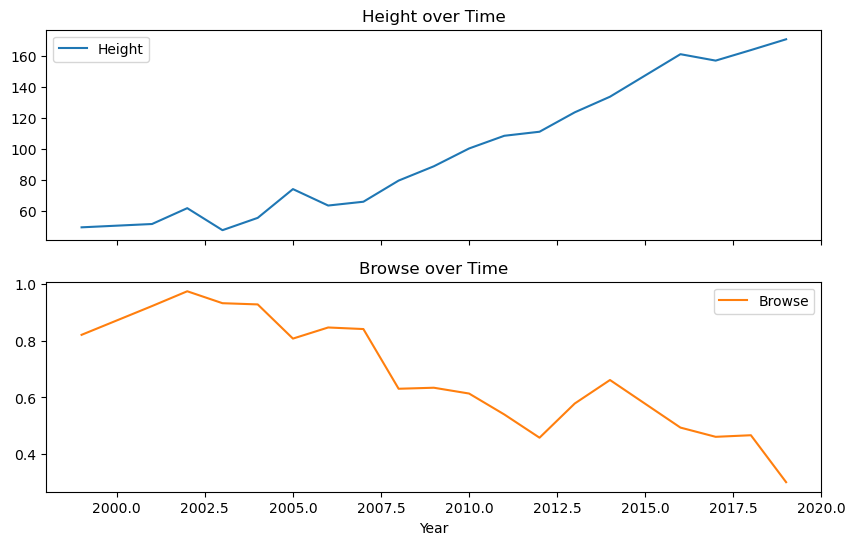

In [9]:
#Average height and browse over time
avg_by_year = df.groupby("Year")[["Height", "Browse"]].mean()
avg_by_year.plot(subplots=True, figsize=(10,6), title=["Height over Time", "Browse over Time"])
plt.show()

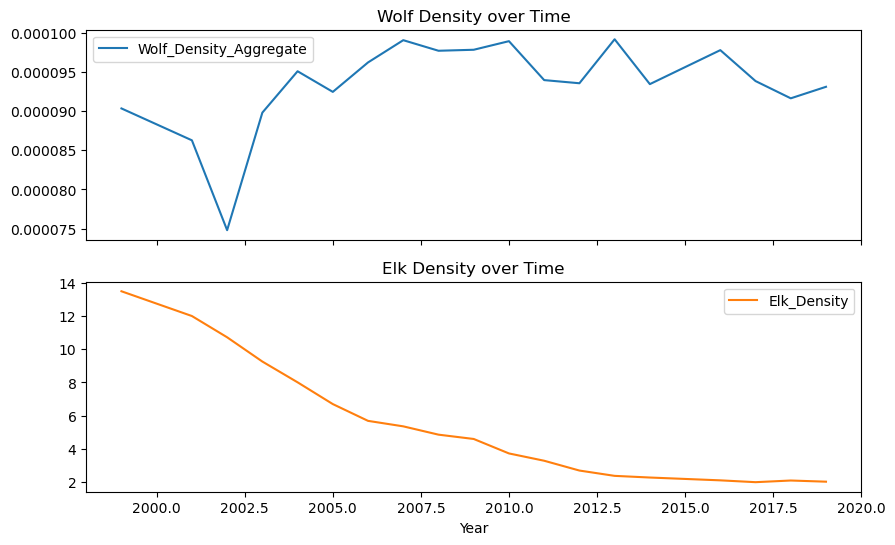

In [10]:
#Average elk and wolves over time
avg_pops_by_year = df.groupby("Year")[["Wolf_Density_Aggregate", "Elk_Density"]].mean()
avg_pops_by_year.plot(subplots=True, figsize=(10,6), title=["Wolf Density over Time", "Elk Density over Time"])
plt.show()

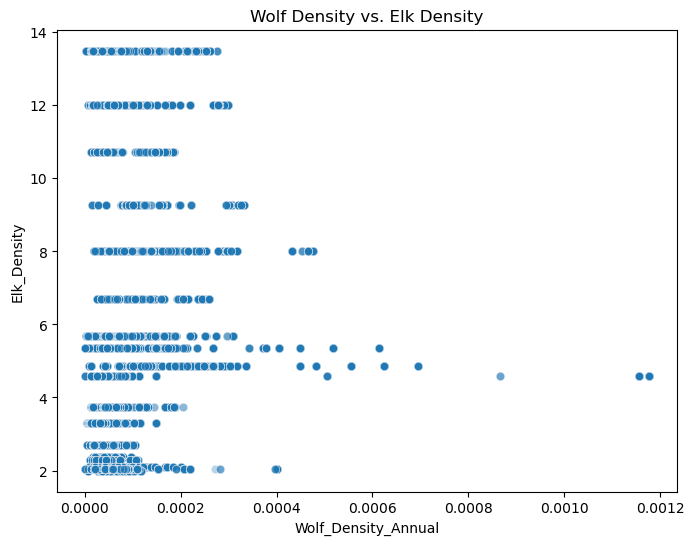

In [11]:
#Relationship between Wolf Density & Elk Density
plt.figure(figsize=(8,6))
sns.scatterplot(x="Wolf_Density_Annual", y="Elk_Density", alpha=0.3, data=df)
plt.title("Wolf Density vs. Elk Density")
plt.show()

Now it's time to write equations to predict the evolution in time of these variables. We'll assume that all variables are continuous (for simplicity of this model). We will translate our assumptions about the interplay between these variables into equations. My hypothesis is that the growth of aspen chutes is partially dependent on the introduction of wolves to control the elk population (which grazes on growing aspen chutes). I'm assuming that as the elk population decreases due to kills by wolves, the height of aspen trees increases.
This is a growth model: I'm interested in the heights of aspen trees over time. We know that elk grazing (Browse) on these trees results in less growth, and we also know that wolves feed on elk, helping to keep the elk population in check and allowing aspen trees to grow. So, I'll consider the following feedback:
<br> Positive feedback: growth rate of tree height, increased wolf population
<br> Negative feedback: elk grazing (Browse) *(we know from the Module 3 lecture that the negative feedback term needs to be non-linear if the positive feedback term is linear)*
<br> We know that any exponential growth at some point hits a carrying capacity, so we need to include that in the model. <br>
From the lecture, we know that this is the SIR model:

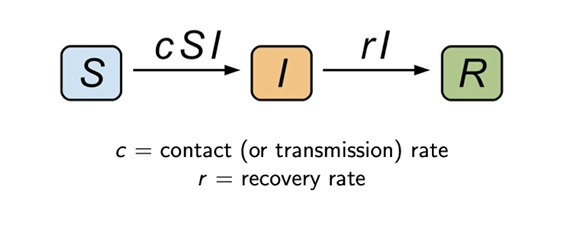

The above model assumes one-way dynamics with no negative feedback; over time, the entire population is infected and subsequently recovers. <br> We can then translate those assumptions into these equations: </br>
$\frac{dS}{dt} = -cSI $
$\frac{dI}{dt} = cSI -rI $
$\frac{dR}{dt} = rI $

So now, let's illustrate our aspen/elk/wolf model:

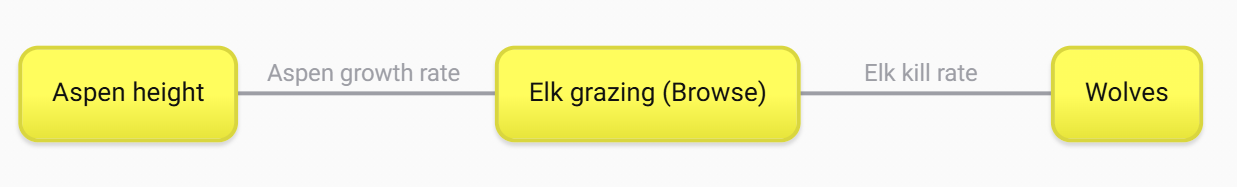

$\frac{dH}{dt} = -Bg $ <br>
$\frac{dE}{dt} = B -rE $ <br>
$\frac{dW}{dt} = W + rE $ </br>
Where $B$ = Browse, $g$ = aspen growth rate, $r$ = elk kill rate, $E$ = Elk density, $W$ = Wolf density <br>
**Since Browse is a binary variable, does this model still work?**

In [21]:
#parameters
B = 0.5
g = 15
r = 0.0000000001

In [22]:
#initial conditions
H0 = 70
E0 = 5
W0 = 0.008
x0 = [H0, E0, W0]

In [23]:
# ODEs
def odes(x,t):
    H = x[0]
    E = x[1]
    W = x[2]
    dHdt = -B*g
    dEdt = B - r*E
    dWdt = W + r*E
    return [dHdt,dEdt,dWdt]

In [24]:
t = np.linspace(0,100,1000)
x = odeint(odes,x0,t)

H = x[:,0]
E = x[:,1]
W = x[:,2]

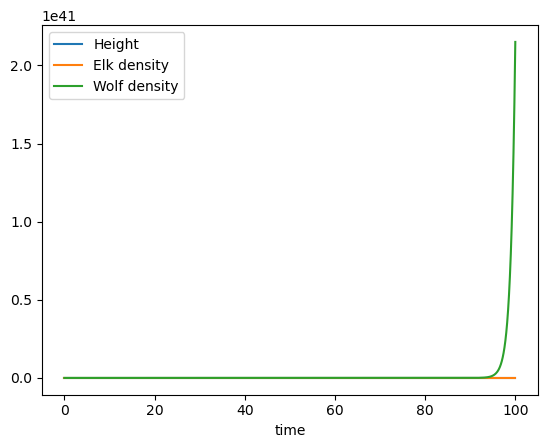

In [25]:
plt.plot(t,H,label='Height')
plt.plot(t,E,label='Elk density')
plt.plot(t,W,label='Wolf density')
plt.legend()
plt.xlabel('time')
plt.show()

I've tried lots of different values for initial conditions and parameters, but nothing I've tried seems to model the data effectively. Perhaps I've made this too difficult on myself, and need to consider a different approach with fewer variables. In one of the office hours calls, my classmate Peter Dresslar mentioned the Lotka-Volterra model; let's give that a go. </br>
The Lotka-Volterra model can be used to describe the predator-prey relationship, and for our use requires the following assumptions: <br>
(1) Only two species exist (in this case, elk and wolves); <br>
(2) Elk are born and die through predation or natural death; and <br>
(3) Wolves are born, and their birth rate is positively affected by the rate of predation, and they die naturally. <br>
This model assumes that the population changes of the predator and the prey are explained in terms of each other. The Lotka–Volterra model uses a pair of first-order, nonlinear, differential equations as follows: <br>
$\frac{dE}{dt} = elk birth rate * E - elk death rate * E * W $ <br>
$\frac{dW}{dt} = wolf birth rate * E * W - wolf death rate * W $ <br>
where $E$ and $W$ are the populations of elk and wolves, respectively.
We can rewrite this in the more general terms of the Lotka-Volterra model: <br>
$$X = \begin{pmatrix} x \\ 
                                             y \end{pmatrix}$$
$$ \dot{X} = \begin{pmatrix} x (\alpha - \beta y) \\
                             y (-\delta + \gamma x) \end{pmatrix} = f(X)$$
</br>The Lotka-Volterra model provides a reasonable modeling environment within which to interpret complex species interactions in the real world. 

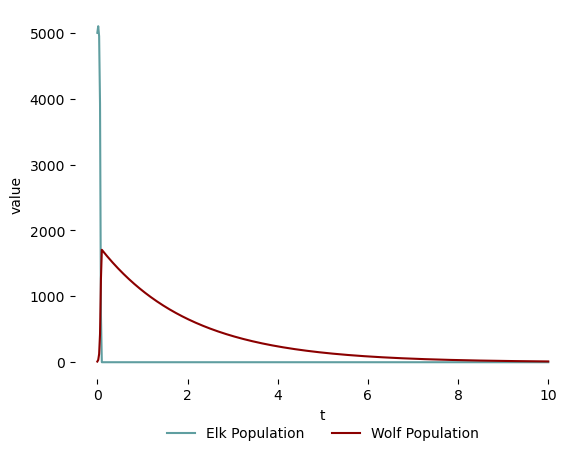

In [55]:
alpha = 2 #natural growth rate of elk
beta = 0.1 #elk death rate due to wolf predation
delta = 0.25 #how many elk kills result in the birth of a new wolf
gamma = 0.5 #natural wolf death rate

def process_step(x, dt, x_0):
    # unpacking elk and wolves from x
    e, w = x

    # the Euler step of our Lotka-Volterra system
    de_dt = alpha * e - beta * e * w
    dw_dt = -gamma * w + delta * beta * e * w
    # and then we need to set the next state vector, remembering that we cannot have negative populations
    e_1 = max(0, e + de_dt * dt)
    w_1 = max(0, w + dw_dt * dt)

    return(e_1, w_1)

# start with 5000 elk, 10 wolves
x_0 = [5000, 10]

# time is the total time period we want to simulate
time = 10
# dt is the time step size
dt = .02
t = int(time / dt)
x = x_0 
e_store = [x_0[0]]
w_store = [x_0[1]]
t_store = [0]

#Iterate over steps in an Euler loop
for i in range(t):
    e_current = e_store[-1] # reference the last value stored
    w_current = w_store[-1]

    e_next, w_next = process_step(x, dt, x_0)

    #update state vector
    x = [e_next, w_next]
    e_store.append(e_next)
    w_store.append(w_next)
    t_store.append(t_store[-1] + dt)

# we can convert to a dataframe to plot
xdf = pd.DataFrame({'Elk Population': e_store, 'Wolf Population': w_store, 't': t_store})

sns.lineplot(pd.melt(xdf, id_vars=['t']), x = 't', y = 'value', hue = 'variable', palette=['cadetblue', 'darkred'])
plt.legend(frameon = False, ncol = 2, loc='lower center', bbox_to_anchor=(.5, -.2))
sns.despine(left = True, bottom = True)

But I'm still curious about aspen growth, particularly given the binary variable 'Browse' from the data set - can we do anything with that? Let's consider the Module 6 lecture materials and my chosen data set. We're told that there are 113 plots of aspen observed for evidence of elk grazing. Though this isn't the case, let's assume for simplicity that these 113 plots are all adjacent; then, we can use the Module 6 finite-state models materials regarding elementary cellular automata (ECA). The lecture gave the example of a wildfire, and that fire can only spread to a plot of land if any plot adjacent is already on fire. Similarly, then, we can think of the aspen plots in the same way - a plot can only be grazed if any plot adjacent to it has been grazed - though, if we started dropping elk in by helicopter, this would change our model :). Perhaps I'm overthinking again, but with the lecture example of ECA about rounds of discussion and people changing their opinions, it was reversible - that is, people who agreed could be convinced to disagree, and vice versa. However, once an aspen chute has been grazed, it can't be un-grazed...so, at what point after it's been grazed do we consider that it can change back to un-grazed? Now I've convinced myself that an ECA model isn't viable until I can determine how a plot can switch back to 'un-grazed' after being grazed.

Thus, this project has come full circle, back to where I started—an exercise in futility. All of the lectures' examples have been simple and well-defined, two traits that real-world data sets, problems, and questions rarely have. So, while I haven't found what I would consider a well-fitting model for the data set I chose and the hypothesis I proposed, I have learned that there is still much more I need to learn before I can adequately tackle this challenge!

**Works Referenced** </br>
Boriello, E. Dynamic methods for complex system science (2025). Arizona State University, CAS-522 (Fall 2025-A) lecture materials. </br>
Brice, E. M., Larsen,  E. J., Stahler, D. R., and MacNulty, D. R. (2024) The primacy of density-mediated indirect effects in a community of wolves, elk, and aspen. Ecological Monographs, 95 (1). https://doi.org/10.1002/ecm.1627 </br>
Dresslar, P. (2025) The Subliminal Wolf. https://github.com/peterdresslar/the-subliminal-wolf/blob/main/the_subliminal_wolf.ipynb
<br>
Shim, H., and Fishwick, P.A. (2008) Visualization and Interaction Design for Ecosystem Modeling. Encyclopedia of Ecology, Academic Press, 3685-3693 https://doi.org/10.1016/B978-008045405-4.00225-1. </br>

